#### 0. Import library, and define constants

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import string
import re
import seaborn as sns
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

Define some constants for later use

In [2]:
INPUT_IMAGES_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"
LABEL_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
OUTPUT_PATH = "/kaggle/working"

# Some special tokens for RNN model...
UNK = "#UNK"
PAD = "#PAD"
START = "#START"
END = "#END"

Read csv file

In [3]:
df = pd.read_csv(LABEL_PATH, sep="|")

In [4]:
df.head()

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

#### 1. Data visualization & analysis

Preprocess raw text to:
1. lower case
2. remove punctuation

In [5]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
def clean_text(row):
    row = str(row).strip()
    row = row.lower()
    return regex.sub("", row)

In [6]:
df.columns = [col.strip() for col in df.columns]
df["comment"] = df["comment"].apply(clean_text)

Compute the length of each sentence and attach it to current dataframe

In [7]:
df["length"] = df["comment"].apply(lambda row: len(row.strip().split()))

In [8]:
df.head()

image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  length  
0  two young guys with shaggy hair look at their ...      16  
1  two young  white males are outside near many b...       9  
2    two men in green shirts are standing in a yard       10  
3        a man in a blue shirt standing in a garden       10  
4             two friends enjoy time spent together        6

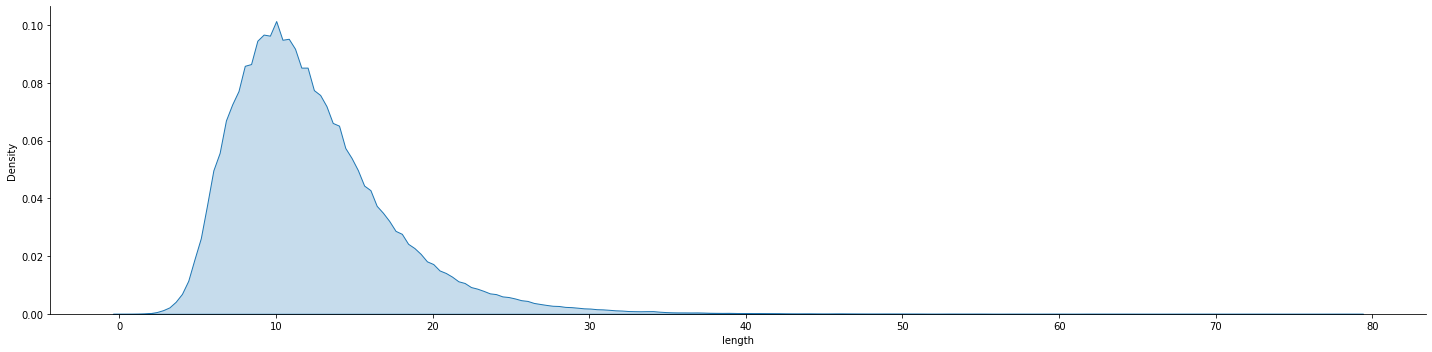

In [9]:
sns.displot(data=df, x='length', palette='mako', kind='kde', fill=True, aspect=4)

Observing that, almost sentence length is <= 30. So I think 30 is good choice as `max_length`

In [10]:
captions = df["comment"].tolist()

In [11]:
captions[:10]

['two young guys with shaggy hair look at their hands while hanging out in the yard ',
 'two young  white males are outside near many bushes ',
 'two men in green shirts are standing in a yard ',
 'a man in a blue shirt standing in a garden ',
 'two friends enjoy time spent together ',
 'several men in hard hats are operating a giant pulley system ',
 'workers look down from up above on a piece of equipment ',
 'two men working on a machine wearing hard hats ',
 'four men on top of a tall structure ',
 'three men on a large rig ']

Do some statistic to count the occurence frequency of words in our captions

In [12]:
word_freq = {}
for caption in captions:
    caption = caption.strip()
    for word in caption.split():
        if word not in word_freq:
            word_freq[word] = 0
        word_freq[word] += 1

See the top 30 words appear the most and the least

In [13]:
dict(sorted(word_freq.items(), key=lambda item: item[1])[:30])

{'portrayed': 1,
 'blitz': 1,
 'bieber': 1,
 'urinals': 1,
 'obliverate': 1,
 'uniformly': 1,
 'colleges': 1,
 'meetings': 1,
 '4wheeled': 1,
 'aross': 1,
 'supple': 1,
 'spaceship': 1,
 'decipher': 1,
 'spectrum': 1,
 'month': 1,
 'jail': 1,
 'bandaid': 1,
 'filler': 1,
 'lowly': 1,
 'entrees': 1,
 'hesitates': 1,
 'relatives': 1,
 'moutains': 1,
 'connects': 1,
 'bassoon': 1,
 'explained': 1,
 'somethings': 1,
 'noddles': 1,
 'papayas': 1,
 'septic': 1}

In [14]:
dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:30])

{'a': 271704,
 'in': 83466,
 'the': 62978,
 'on': 45669,
 'and': 44263,
 'man': 42598,
 'is': 41117,
 'of': 38776,
 'with': 36207,
 'woman': 22211,
 'two': 21642,
 'are': 20196,
 'to': 17607,
 'people': 17337,
 'at': 16259,
 'an': 15883,
 'wearing': 15709,
 'young': 13218,
 'white': 13178,
 'shirt': 12981,
 'black': 12311,
 'while': 11711,
 'his': 11495,
 'blue': 11310,
 'red': 9916,
 'girl': 9655,
 'sitting': 9620,
 'men': 9498,
 'boy': 9429,
 'standing': 9113}

#### 2. Data preparation

By having preprocessed captions, we start to build vocabulary in our dataset and convert string to token

In [15]:
def build_vocab(captions, word_freq, count_threshold=5):
    """
    This function builds `vocab` dictionary from list of text captions.
    Also, add constant PAD, UNK, START, END to `vocab`.
    Add a word to vocab if its occurence frequency is larger than `count_threshold`
    
    Parameters
    ----------
    captions: a list of preprocessed text captions above.
    word_freq: a dictionary of word occurence frequency.
    count_threshold: a int to use when building vocab.

    Returns
    -------
    vocab: an dictionary vocabulary of key-value pair which is:
        -> key: string text
        -> value:  token index
    inv_vocab: an inverse dictionary vocabulary of key-value pair which is:
        -> key: token index
        -> value: string text
        
    E.g: vocab = {"two": 4, "young": 5, "guys": 6, ...} 
         inv_vocab = {4: "two", 5: "young", 6: "guys", ...}
    """
    vocab = {
        PAD: 0,
        UNK: 1,
        START: 2,
        END: 3
    }
    index = 4
    
    for caption in captions:
        caption = caption.strip().split(" ")
        for word in caption:
            if word and word_freq[word] >= count_threshold and word not in vocab:
                vocab[word] = index
                index += 1

    inv_vocab = {v: k for k, v in vocab.items()}
    return vocab, inv_vocab

In [16]:
vocab, inv_vocab = build_vocab(captions, word_freq)

In [17]:
def convert_captions(captions, vocab, max_length=30):
    """
    Convert text captions to index token based on `vocab`.
    If a word not in vocab, replace it by the token index of `UNK` constant.
    Also, add `START` constant to the beginning of the sentence and 
            `END` constant to the end of the sentence.
    After add `START` and `END` constant, if the length is still < 30,
        use `PAD` constant to fill remaining positions.
        
    Parameters
    ----------
    captions: a list of preprocessed text captions above.
    vocab: a dictionary vocabulary of key-value pair which is:
        -> key: string text
        -> value: token index
    max_length: an int denotes fixed maximum length to the captions.
    
    Returns
    -------
    tokens: a list of tokens get from `vocab`
    """
    tokens = [[vocab[PAD]]*max_length for _ in range(len(captions))]
    for i, caption in enumerate(captions):
        caption = caption.strip().split()
        tokens[i][0] = vocab[START]
        j = 1
        for word in caption[:max_length-2]:
            if word not in vocab:
                tokens[i][j] = vocab[UNK]
            else:
                tokens[i][j] = vocab[word]
            j += 1
        tokens[i][j] = vocab[END]
    return tokens

In [18]:
tokens = convert_captions(captions, vocab)
img_paths = list(df["image_name"])

Define pytorch Dataset class

In [19]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    
    def __init__(self, img_paths, tokens):
        """
        img_paths: a list of image path we get from dataframe
        tokens: a list of tokens that we converted from text captions
        """
        self.img_paths = [os.path.join(INPUT_IMAGES_DIR, p) for p in img_paths]
        self.tokens = tokens
        assert len(self.img_paths) == len(self.tokens), "Make sure len(img_paths) == len(tokens)."
    
    def __getitem__(self, index):
        """
        Get image path and token. Then load image path to numpy array image. Convert to pytorch tensor if it's necessary. 
        """
        img_path = self.img_paths[index]
        token = self.tokens[index]
        img = cv2.imread(img_path)
        img = self._resize_img(img, shape=(300, 300))
        img = torchvision.transforms.ToTensor()(img)
        token = torch.as_tensor(token)
        return img, token
    
    def __len__(self):
        return len(self.img_paths)

    def _resize_img(self, img, shape=(300, 300)):
        h, w = img.shape[0], img.shape[1]
        pad_left = 0
        pad_right = 0
        pad_top = 0
        pad_bottom = 0
        if h > w:
            diff = h - w
            pad_top = diff - diff // 2
            pad_bottom = diff // 2
        else:
            diff = w - h
            pad_left = diff - diff // 2
            pad_right = diff // 2
        cropped_img = img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]
        cropped_img = cv2.resize(cropped_img, shape)
        return cropped_img

In [20]:
dataset = ImageCaptioningDataset(img_paths, tokens)

#### 3. Model architecture

A picture is better than thoudsand words:
![Image Captioning Model](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

In this architecture, the encoder is CNN which outputs a feature vector. Then, the decoder RNN (LSTM) uses this feature vector as initial hidden states.

In [21]:
MAX_LENGTH = 30
NUM_VOCAB = len(vocab)
BATCH_SIZE = 128
EPOCH = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

##### 3.1 Define CNN encoder class:

The best practice is to use pretrained models from ImageNet: VGG, Resnet, Alexnet, Googlenet,... We can call those pretrained models are the backbones.

In [22]:
class CNNEncoder(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.cnn = torchvision.models.resnet34(pretrained=True)

    def forward(self, img):
        return self.cnn(img)


##### 3.2 Define LSTM decoder class:

In this class, you should have to define nn.Embedding, nn.LSTM, nn.Linear,... to appropriate training model.

In [23]:
class RNNDecoder(nn.Module):

    def __init__(self, num_vocab) -> None:
        super().__init__()
        self.bottleneck = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.num_vocab = num_vocab
        self.embedding = nn.Embedding(num_embeddings=num_vocab, embedding_dim=256, padding_idx=0)
        self.num_layers = 1
        self.bidirectional = False
        self.rnn = nn.LSTM(input_size=256, hidden_size=256, num_layers=self.num_layers, batch_first=True, bidirectional=self.bidirectional)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, num_vocab)
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, img_embeded, prediction=False):
        img_embeded = self.bottleneck(img_embeded)
        img_embeded = torch.stack([img_embeded]*(self.num_layers), dim=0)
        if prediction:
            output = []
            hidden = (img_embeded, img_embeded)
            out = input
            while out != vocab[END] and len(output) <= MAX_LENGTH:
                out = torch.tensor([[out]]).to("cuda")
                out = self.embedding(out)
                out, hidden = self.rnn(out, hidden)
                out = self.classifier(out)
                out = self.softmax(out)
                out = torch.argmax(out, dim=-1)
                out = out.squeeze().item()
                output.append(out)
        else:
            input = self.embedding(input)
            output, (h, c) = self.rnn(input, (img_embeded, img_embeded))
            output = self.classifier(output)
        return output

#### 4. Train model

In this part, you should combine what you defined to train model (Dataset, Encoder, Decoder,...)

In [24]:
class ImageCaptioningModel:

    def __init__(self, encoder : CNNEncoder, decoder : RNNDecoder, train_dataset : ImageCaptioningDataset):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.encoder = encoder.to(self.device)
        self.encoder.eval()
        self.decoder = decoder.to(self.device)
        self.train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        self.optimizer = optim.Adam(decoder.parameters())
        self.loss = nn.CrossEntropyLoss()

    def predict(self, img):
        with torch.no_grad():
            img_embed = self.encoder(img)
            caption = vocab[START]
            caption = self.decoder(caption, img_embed, prediction=True)
        
        text = [inv_vocab[t] for t in caption]
        text = " ".join(text)
        return text
    
    def train(self):
        for e in range(EPOCH):
            pbar = tqdm(self.train_dataloader, desc="Epoch: {}".format(e+1))
            for i, (img, caption) in enumerate(pbar):
                img = img.to(self.device)
                caption = caption.to(self.device)
                img_embed = self.encoder(img)
                output = self.decoder(caption[:, :-1], img_embed)
                output = output.permute(0, 2, 1)
                loss = self.loss(output, caption[:, 1:])

                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step()

                pbar.set_description(desc="Epoch " + str(e+1) + " - Loss: %.5f" % (loss.item()))
                
                if ((i+1)%100) == 0:
                    plt.imshow(img[-1].cpu().detach().numpy().transpose((1, 2, 0)))
                    output = self.predict(img[-1].unsqueeze(0))
                    plt.title(output)
                    plt.show()

In [25]:
cnn = CNNEncoder()
rnn = RNNDecoder(num_vocab=NUM_VOCAB)
model = ImageCaptioningModel(encoder=cnn, decoder=rnn, train_dataset=dataset)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 1 - Loss: 2.26082:   8%|▊         | 99/1242 [04:09<43:50,  2.30s/it] 

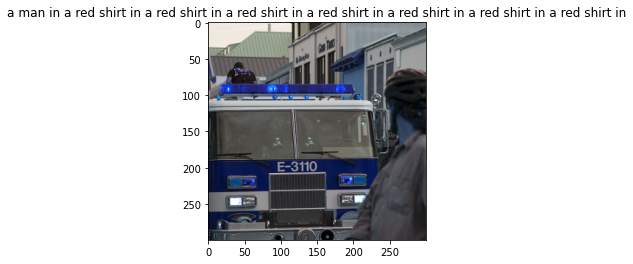

Epoch 1 - Loss: 1.90712:  16%|█▌        | 199/1242 [07:50<36:42,  2.11s/it]

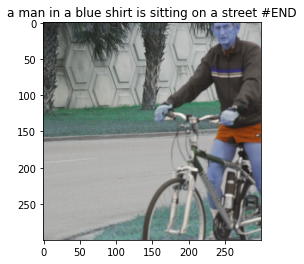

Epoch 1 - Loss: 1.73162:  24%|██▍       | 299/1242 [11:14<30:34,  1.95s/it]

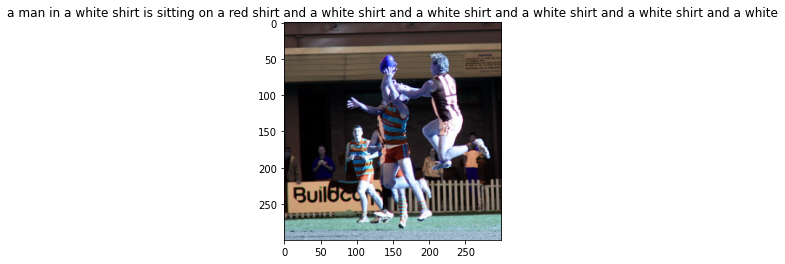

Epoch 1 - Loss: 1.78652:  32%|███▏      | 399/1242 [14:24<26:27,  1.88s/it]

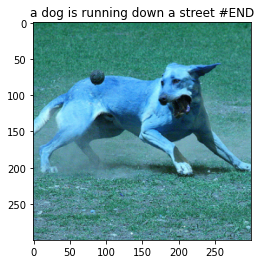

Epoch 1 - Loss: 1.64295:  40%|████      | 499/1242 [17:27<22:06,  1.78s/it]

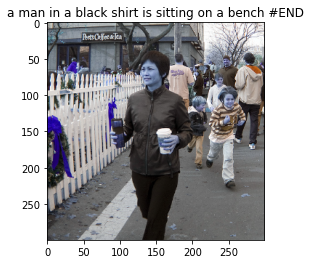

Epoch 1 - Loss: 1.78937:  48%|████▊     | 599/1242 [20:24<18:18,  1.71s/it]

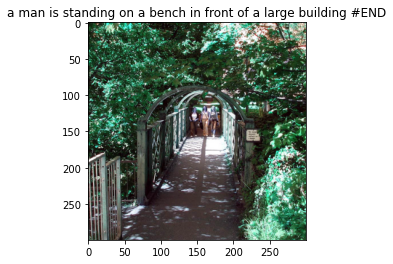

Epoch 1 - Loss: 1.61817:  56%|█████▋    | 699/1242 [23:16<15:17,  1.69s/it]

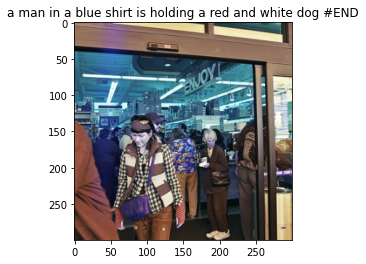

Epoch 1 - Loss: 1.67599:  64%|██████▍   | 799/1242 [26:06<12:51,  1.74s/it]

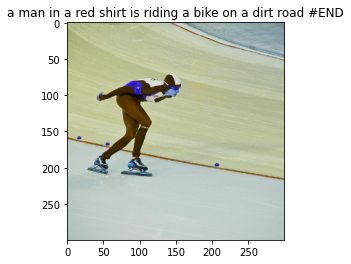

Epoch 1 - Loss: 1.62391:  72%|███████▏  | 899/1242 [28:54<09:35,  1.68s/it]

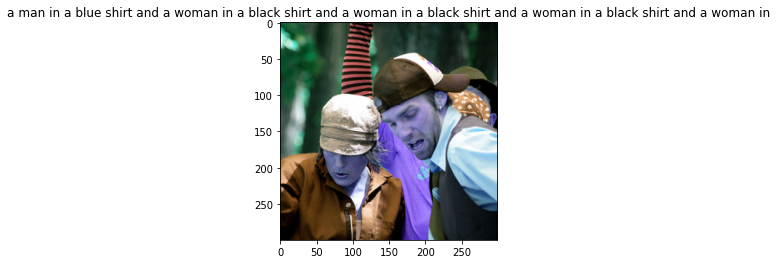

Epoch 1 - Loss: 1.58176:  80%|████████  | 999/1242 [31:42<06:36,  1.63s/it]

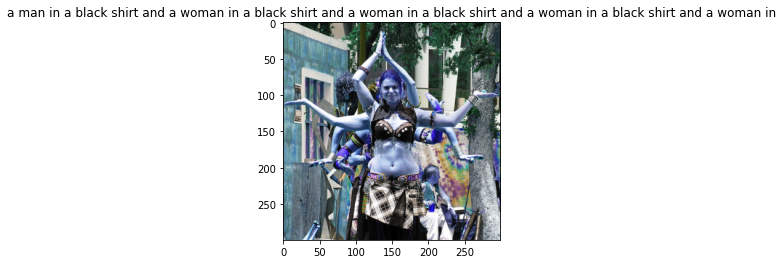

Epoch 1 - Loss: 1.69601:  88%|████████▊ | 1099/1242 [34:28<04:01,  1.69s/it]

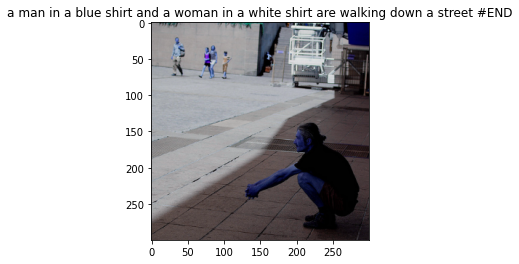

Epoch 1 - Loss: 1.60937:  97%|█████████▋| 1199/1242 [37:15<01:12,  1.69s/it]

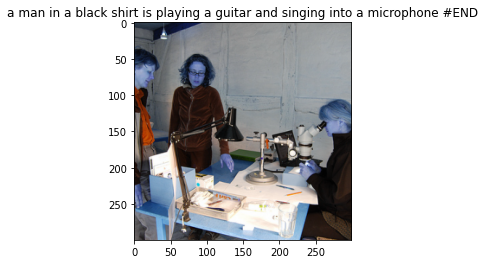

Epoch 2 - Loss: 1.45247:   8%|▊         | 99/1242 [02:45<32:46,  1.72s/it]

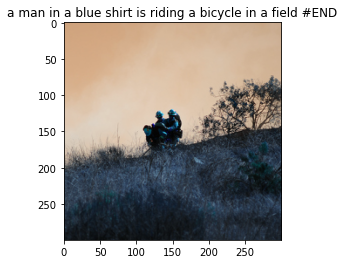

Epoch 2 - Loss: 1.46969:  16%|█▌        | 199/1242 [05:33<28:39,  1.65s/it]

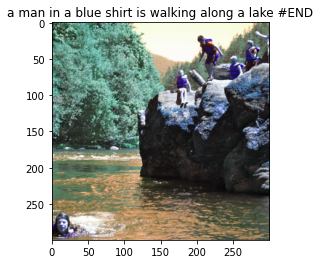

Epoch 2 - Loss: 1.41204:  24%|██▍       | 299/1242 [08:20<26:27,  1.68s/it]

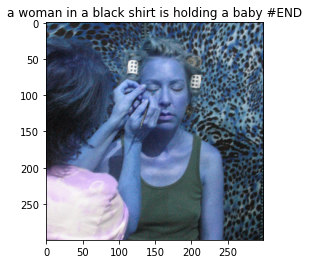

Epoch 2 - Loss: 1.56233:  32%|███▏      | 399/1242 [11:06<23:11,  1.65s/it]

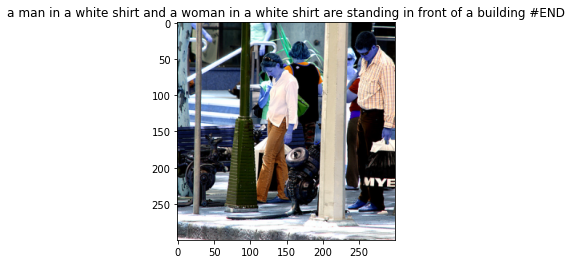

Epoch 2 - Loss: 1.42799:  40%|████      | 499/1242 [13:53<20:12,  1.63s/it]

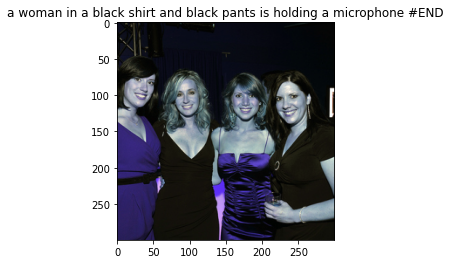

Epoch 2 - Loss: 1.38836:  48%|████▊     | 599/1242 [16:40<17:39,  1.65s/it]

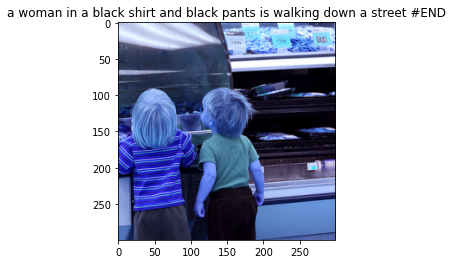

Epoch 2 - Loss: 1.51148:  56%|█████▋    | 699/1242 [19:27<14:55,  1.65s/it]

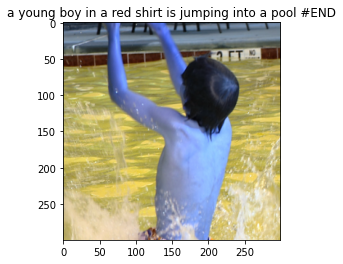

Epoch 2 - Loss: 1.39140:  64%|██████▍   | 799/1242 [22:13<12:06,  1.64s/it]

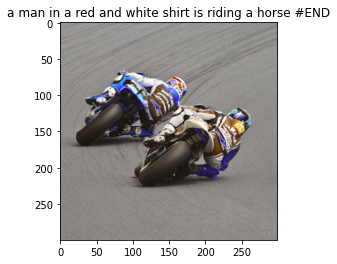

Epoch 2 - Loss: 1.42723:  72%|███████▏  | 899/1242 [25:00<09:43,  1.70s/it]

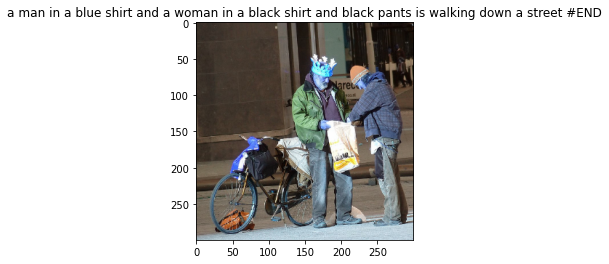

Epoch 2 - Loss: 1.45209:  80%|████████  | 999/1242 [27:47<06:44,  1.66s/it]

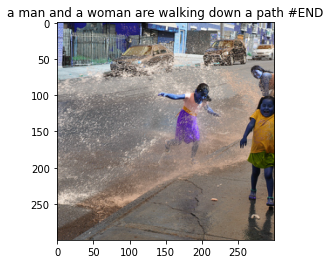

Epoch 2 - Loss: 1.32230:  88%|████████▊ | 1099/1242 [30:34<03:54,  1.64s/it]

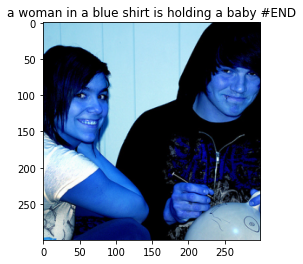

Epoch 2 - Loss: 1.55590:  97%|█████████▋| 1199/1242 [33:20<01:10,  1.65s/it]

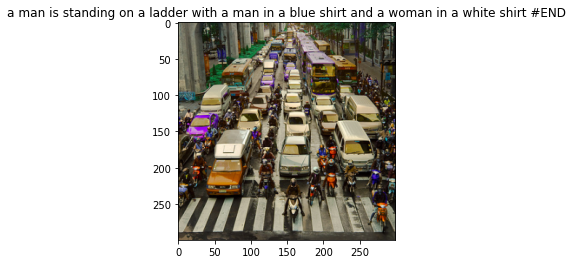

Epoch 3 - Loss: 1.34553:   8%|▊         | 99/1242 [02:46<32:22,  1.70s/it]

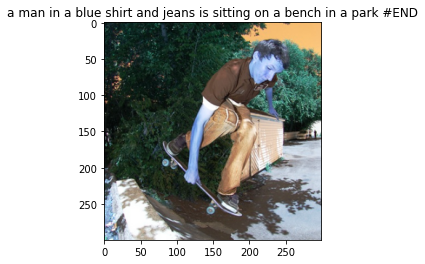

Epoch 3 - Loss: 1.36164:  16%|█▌        | 199/1242 [05:32<28:37,  1.65s/it]

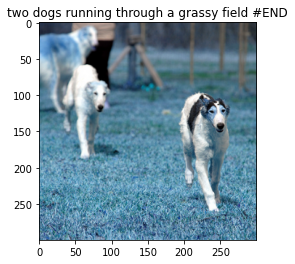

Epoch 3 - Loss: 1.33611:  24%|██▍       | 299/1242 [08:21<25:57,  1.65s/it]

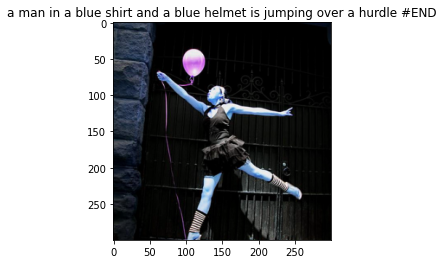

Epoch 3 - Loss: 1.35397:  32%|███▏      | 399/1242 [11:08<23:33,  1.68s/it]

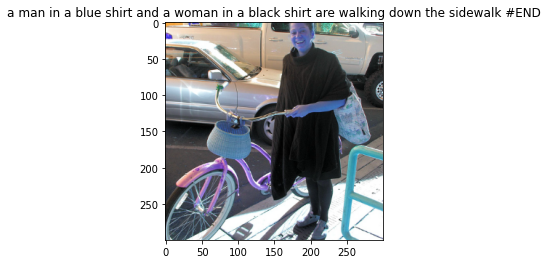

Epoch 3 - Loss: 1.33736:  40%|████      | 499/1242 [13:55<20:22,  1.65s/it]

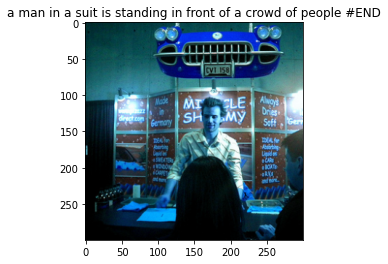

Epoch 3 - Loss: 1.36750:  48%|████▊     | 599/1242 [16:42<17:39,  1.65s/it]

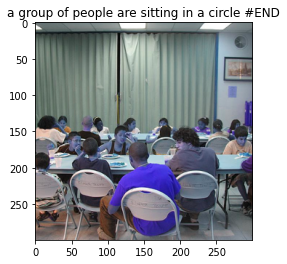

Epoch 3 - Loss: 1.41684:  56%|█████▋    | 699/1242 [19:30<15:23,  1.70s/it]

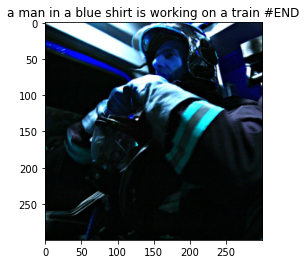

Epoch 3 - Loss: 1.38237:  64%|██████▍   | 799/1242 [22:18<12:17,  1.67s/it]

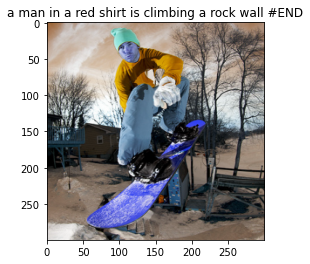

Epoch 3 - Loss: 1.35581:  72%|███████▏  | 899/1242 [25:04<09:29,  1.66s/it]

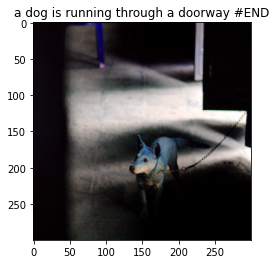

Epoch 3 - Loss: 1.34602:  80%|████████  | 999/1242 [27:52<06:38,  1.64s/it]

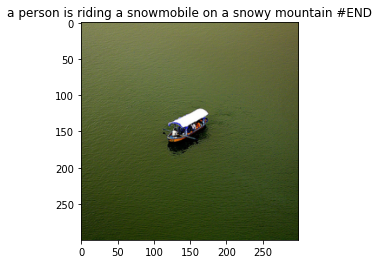

Epoch 3 - Loss: 1.37457:  88%|████████▊ | 1099/1242 [30:39<03:56,  1.65s/it]

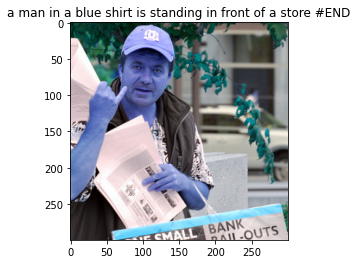

Epoch 3 - Loss: 1.34348:  97%|█████████▋| 1199/1242 [33:27<01:15,  1.75s/it]

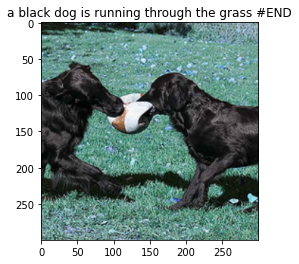

Epoch 4 - Loss: 1.28498:   8%|▊         | 99/1242 [02:46<31:36,  1.66s/it]

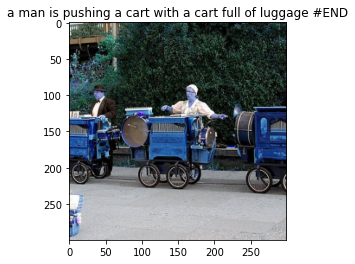

Epoch 4 - Loss: 1.28747:  16%|█▌        | 199/1242 [05:34<28:34,  1.64s/it]

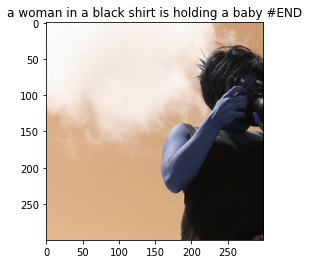

Epoch 4 - Loss: 1.25394:  24%|██▍       | 299/1242 [08:20<25:57,  1.65s/it]

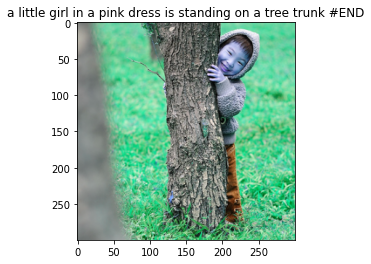

Epoch 4 - Loss: 1.26910:  32%|███▏      | 399/1242 [11:08<23:48,  1.69s/it]

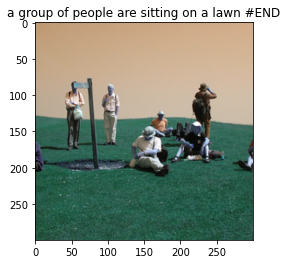

Epoch 4 - Loss: 1.29994:  40%|████      | 499/1242 [13:55<20:33,  1.66s/it]

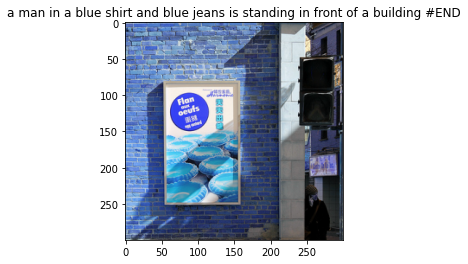

Epoch 4 - Loss: 1.26639:  48%|████▊     | 599/1242 [16:42<17:52,  1.67s/it]

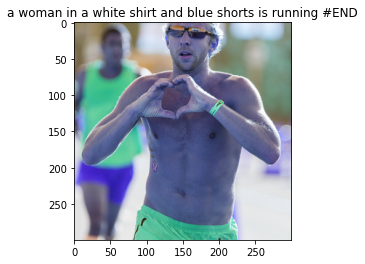

Epoch 4 - Loss: 1.18138:  56%|█████▋    | 699/1242 [19:28<14:48,  1.64s/it]

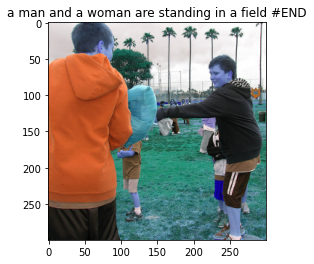

Epoch 4 - Loss: 1.27538:  64%|██████▍   | 799/1242 [22:15<12:05,  1.64s/it]

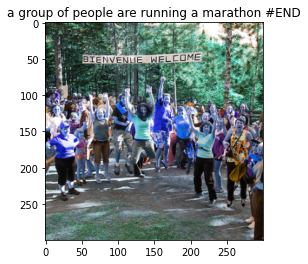

Epoch 4 - Loss: 1.26748:  72%|███████▏  | 899/1242 [25:01<09:22,  1.64s/it]

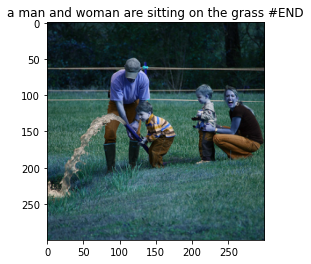

Epoch 4 - Loss: 1.25808:  80%|████████  | 999/1242 [27:49<07:00,  1.73s/it]

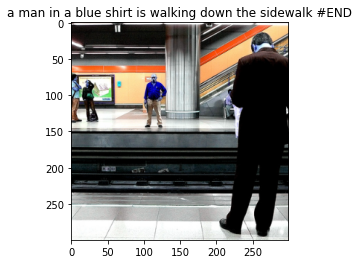

Epoch 4 - Loss: 1.29570:  88%|████████▊ | 1099/1242 [30:35<03:56,  1.66s/it]

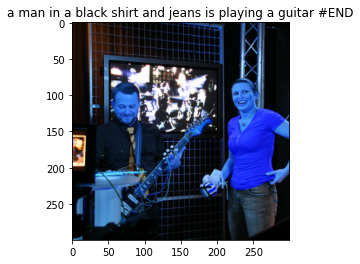

Epoch 4 - Loss: 1.27997:  97%|█████████▋| 1199/1242 [33:23<01:11,  1.66s/it]

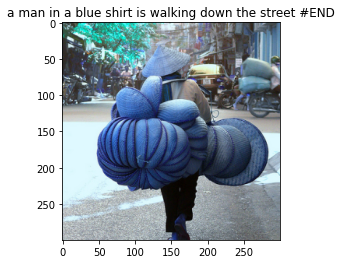

Epoch 5 - Loss: 1.22984:   8%|▊         | 99/1242 [02:46<32:22,  1.70s/it]

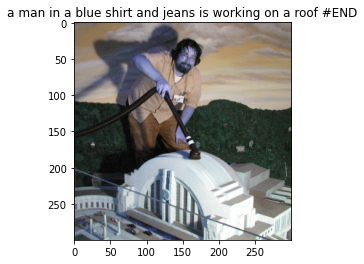

Epoch 5 - Loss: 1.21825:  16%|█▌        | 199/1242 [05:34<29:41,  1.71s/it]

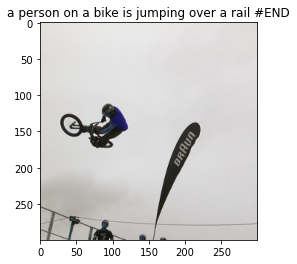

Epoch 5 - Loss: 1.21134:  24%|██▍       | 299/1242 [08:21<26:43,  1.70s/it]

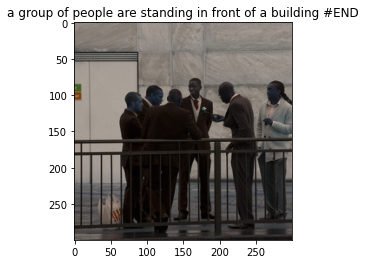

Epoch 5 - Loss: 1.14083:  32%|███▏      | 399/1242 [11:11<23:18,  1.66s/it]

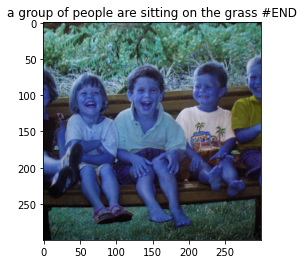

Epoch 5 - Loss: 1.22490:  40%|████      | 499/1242 [14:00<20:50,  1.68s/it]

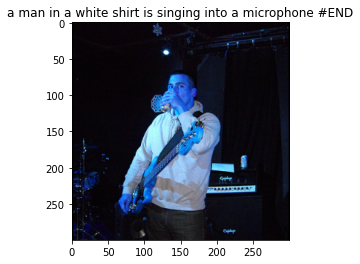

Epoch 5 - Loss: 1.33002:  48%|████▊     | 599/1242 [16:48<17:52,  1.67s/it]

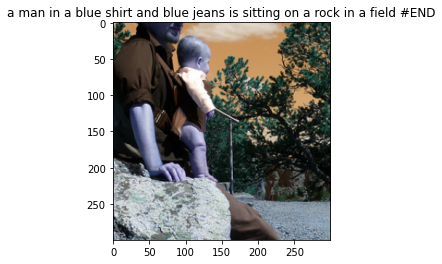

Epoch 5 - Loss: 1.26658:  56%|█████▋    | 699/1242 [19:38<16:03,  1.77s/it]

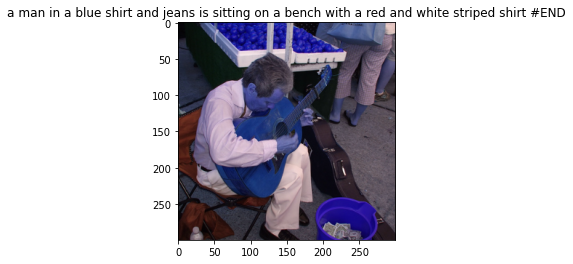

Epoch 5 - Loss: 1.24644:  64%|██████▍   | 799/1242 [22:26<12:21,  1.67s/it]

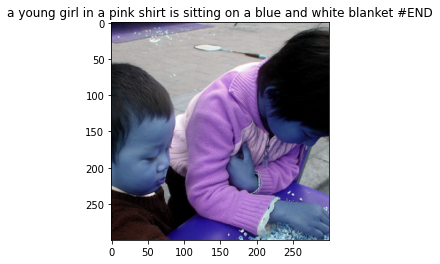

Epoch 5 - Loss: 1.10126:  72%|███████▏  | 899/1242 [25:17<09:33,  1.67s/it]

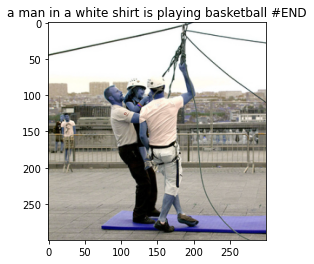

Epoch 5 - Loss: 1.21624:  80%|████████  | 999/1242 [28:08<06:41,  1.65s/it]

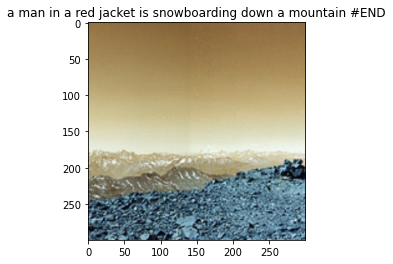

Epoch 5 - Loss: 1.15882:  88%|████████▊ | 1099/1242 [30:56<03:54,  1.64s/it]

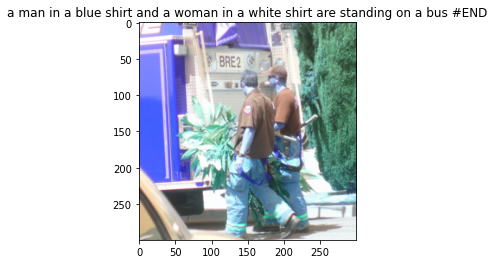

Epoch 5 - Loss: 1.22621:  97%|█████████▋| 1199/1242 [33:43<01:11,  1.66s/it]

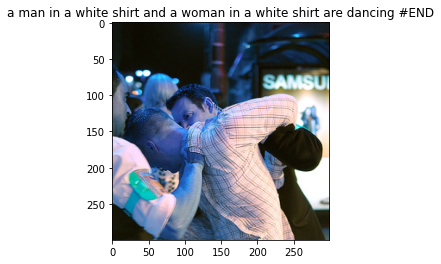

Epoch 5 - Loss: 1.28792: 100%|██████████| 1242/1242 [34:52<00:00,  1.68s/it]


In [26]:
model.train()

#### 5. Save model

In [62]:
torch.save(model,'./final_model.h5')

In [67]:
m1 = './final_model.h5'
mod = torch.load(m1)
mod

### 6. Predict

a group of people are performing on stage #END


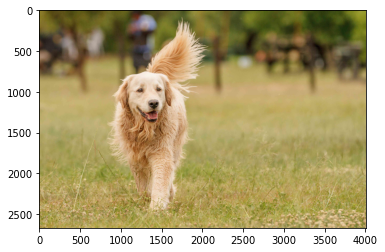

In [55]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
img = '../input/sample/1.jpg'
image = Image.open(img)
transform = transforms.Compose([
    transforms.PILToTensor()
])
img_tensor = transform(image)
output = model.predict(img_tensor.float().unsqueeze(0).cuda())
print(output)
plt.imshow(image)